In [1]:
from jedi import jedi
from jedi.utils import plot, seedutil, func_generator, init_tools

from functools import partial
import random
import types
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from __future__ import division
from scipy.integrate import odeint, ode
from numpy import zeros,ones,eye,tanh,dot,outer,sqrt,linspace, \
    cos,pi,hstack,zeros_like,abs,repeat
from numpy.random import uniform,normal,choice
import numpy.linalg as la

from ipywidgets import interact, fixed
from sklearn.decomposition import PCA

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
reload(jedi)
reload(seedutil)

<module 'jedi.utils.seedutil' from '/Users/simonhaxby/Code/Python/jedi/utils/seedutil.pyc'>

In [3]:
# Setting Seeds
seeds = random.sample(range(100000), 1)

### Comparing thresholds

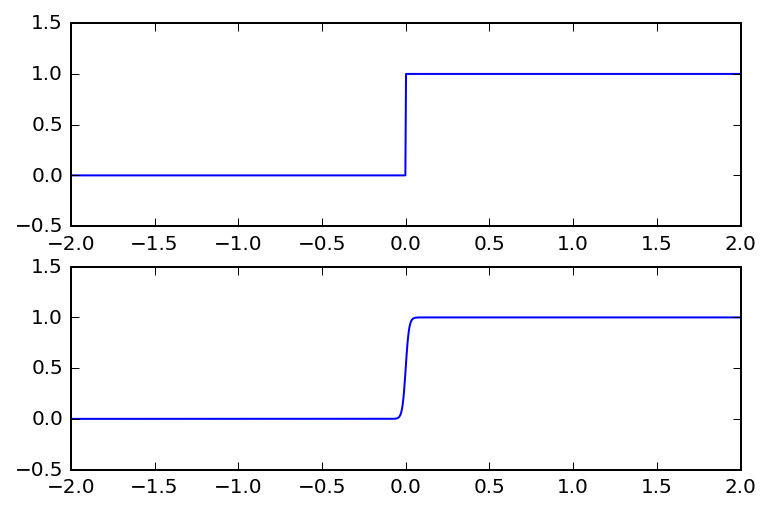

In [4]:
t = linspace(-2,2,1000)
plt.subplot(2,1,1)
plt.plot(t, jedi.step_decode(t));
plt.ylim(-0.5,1.5)

delta = 100
plt.subplot(2,1,2)
plt.plot(t, jedi.sigmoid(delta, t));
plt.ylim(-.5,1.5);

# Test Signals

## 1) Sin Wave

In [5]:
reload(jedi)
reload(seedutil)

<module 'jedi.utils.seedutil' from '/Users/simonhaxby/Code/Python/jedi/utils/seedutil.pyc'>

In [6]:
# sine-wave target
target = lambda t0: cos(2 * pi * t0/.5)

In [55]:
# simulation parameters for FORCE
dt = .01      # time step
tmax = 10  # simulation length
tstop = 5  # learning stop time
rho = 1.02   # spectral radius of J
N = 300      # size of stochastic pool
lr = 1.0   # learning rate
pE = .8 # percent excitatory
sparsity = (.1,1,1) # sparsity

In [56]:
errors = []

for seedling in seeds:
    J, Wz, _, x0, u, w = init_tools.set_simulation_parameters(seedling, N, 1, pE=pE, p=sparsity, rho=rho)
    
    # inp & z are dummy variables
    def model(t0, x, tanh_x, inp, z): 
        return (-x + dot(J, tanh_x) + Wz*z)/dt 
    
    x, t, z, _, wu,_ = jedi.force(target, model, lr, dt, tmax, tstop, x0, w, 0)

    error = np.abs(z-target(t))
    errors.append(error)
    
errors = np.array(errors)

Simulation run-time (wall): 3.352 seconds


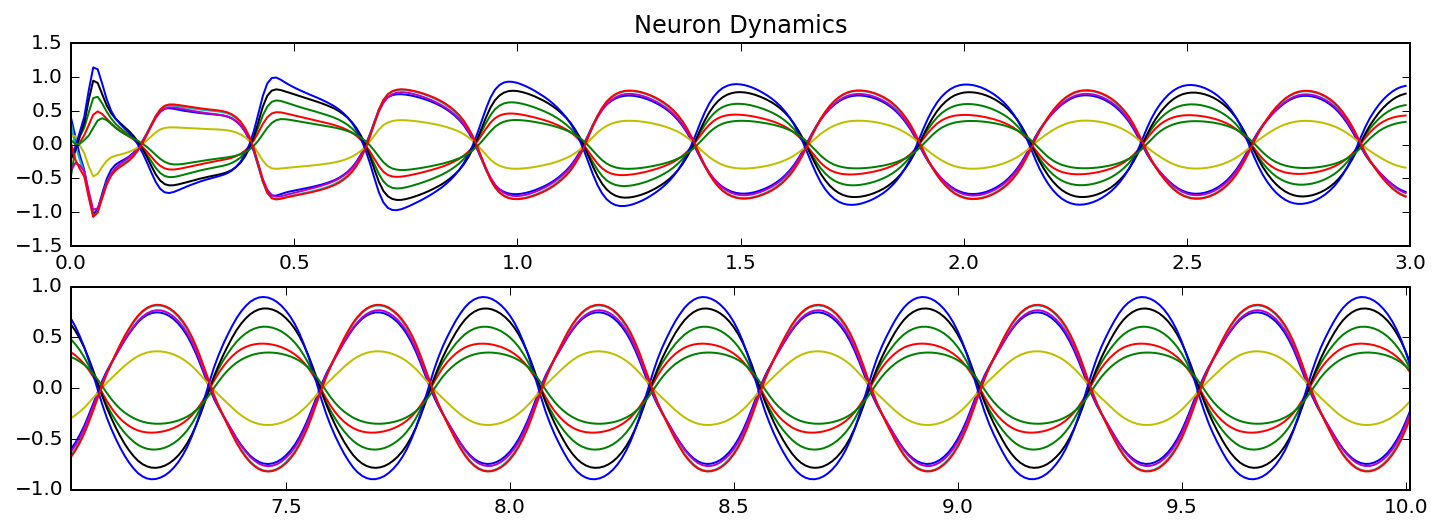

In [57]:
# Visualizing activities of first 20 neurons
T = 300
plt.figure(figsize=(12,4))
plt.subplot(211)
plt.title("Neuron Dynamics");
for i in range(10):
    plt.plot(t[:T], x[:T, i]);
    
plt.subplot(212)
for i in range(10):
    plt.plot(t[-T:], x[-T:, i]);
    plt.xlim(t[-T], t[-1])

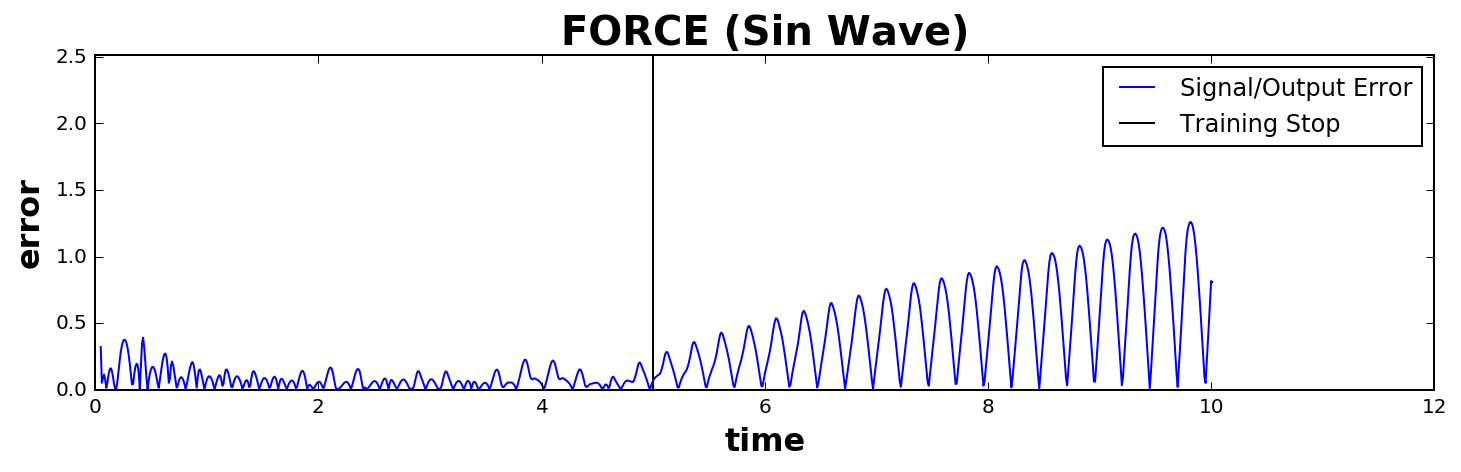

In [58]:
plt.figure(figsize=(12,3))
plot.signal_error(errors, t, tstop, title= "FORCE (Sin Wave)", burn_in=5)

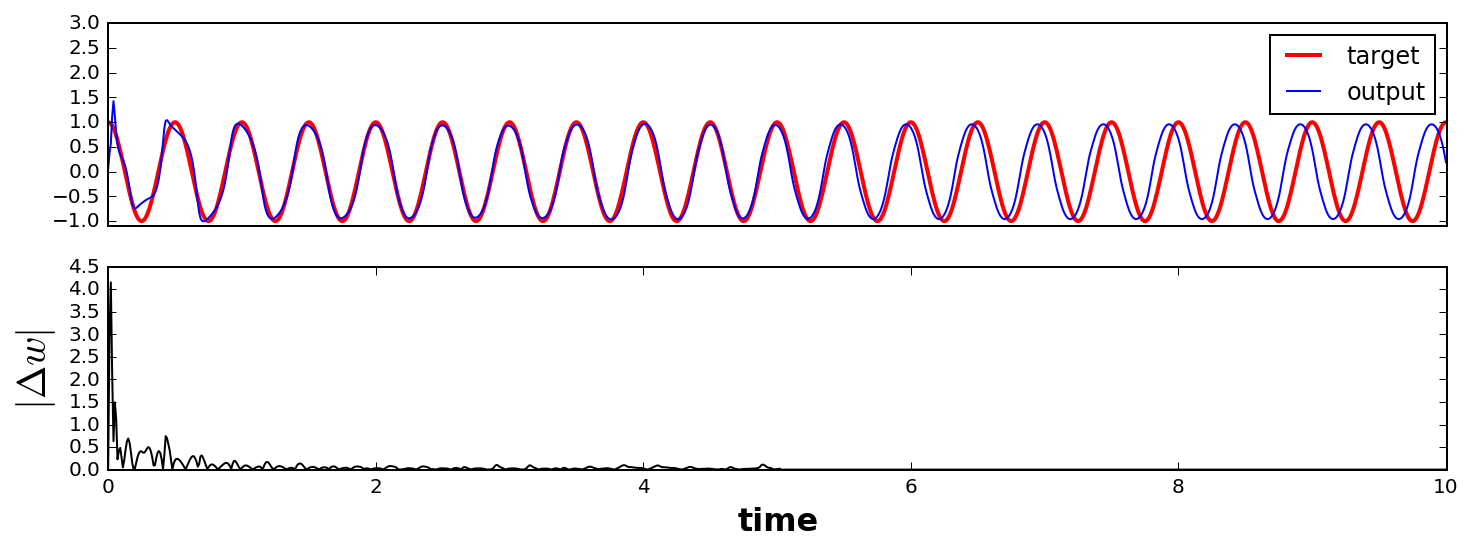

In [59]:
plt.figure(figsize=(12,4))
plot.target_vs_output_plus_error(t, z, wu, target, offset=1, log=False)

In [12]:
pca = PCA(n_components=2)
pca.fit(x)
pca_x = pca.transform(x).T

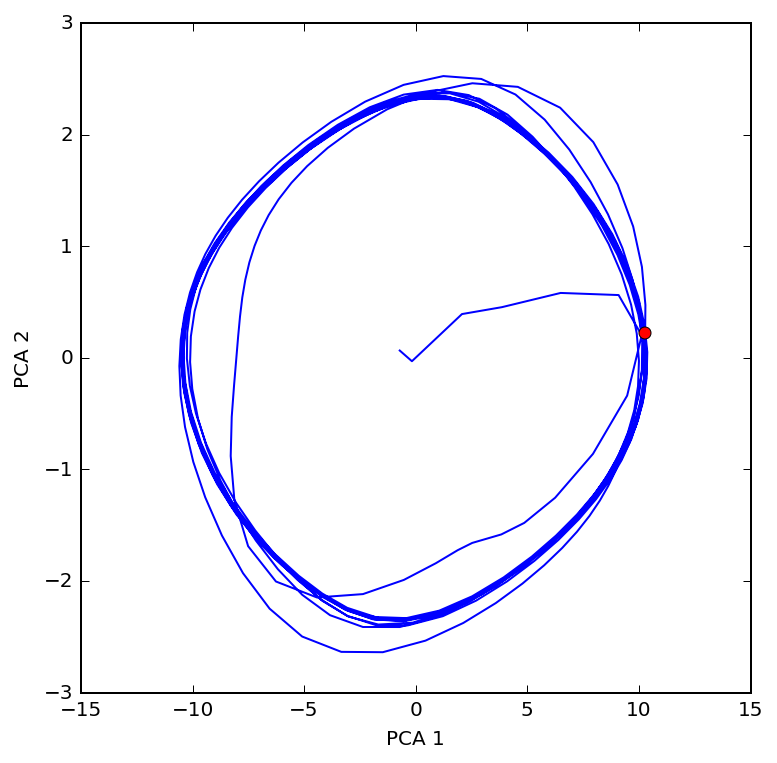

In [13]:
tmax = t[-1]
tmin = t[0]
tv = t[:-1]

interact(plot.visualize_2dim_state, time=(tmin, tmax, .1), pca_x=fixed(pca_x), tv=fixed(tv));

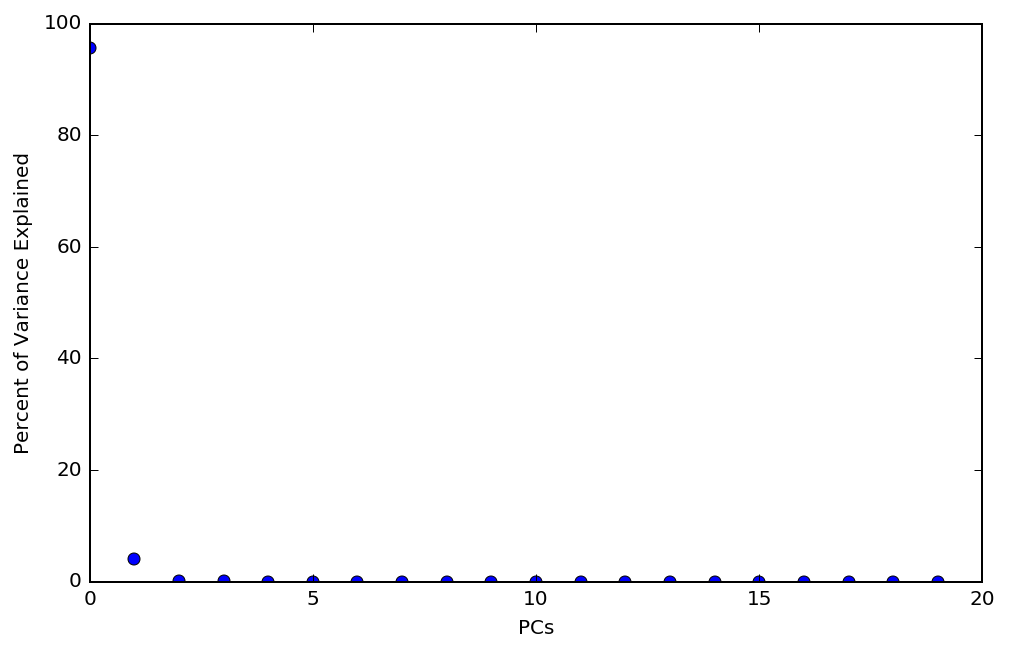

In [14]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(x)

plt.figure(figsize=(8,5))
plt.plot(100*pca.explained_variance_/sum(pca.explained_variance_), 'bo');
plt.xlabel("PCs");
plt.ylabel("Percent of Variance Explained");

In [15]:
partial?

In [16]:
reload(jedi)
reload(seedutil)

<module 'jedi.utils.seedutil' from '/Users/simonhaxby/Code/Python/jedi/utils/seedutil.pyc'>

In [17]:
jedi.dforce?

In [18]:
# simulation parameters for FORCE
dt = .01      # time step
tmax = 10  # simulation length
tstop = 5  # learning stop time
rho = 1.02   # spectral radius of J
N = 300      # size of stochastic pool
lr = 1.0   # learning rate
pE = .8 # percent excitatory
sparsity = (.1,1,1) # sparsity

In [19]:
derrors = []

for seed in seeds:
    J, Wz, _, x0, u, w = init_tools.set_simulation_parameters(seedling, N, 1, pE=pE, p=sparsity, rho=rho)
    
    def model(t0, x, tanh_x, inp, z): 
        return (-x + dot(J, tanh_x) + Wz*z)/dt 

    x, t, z, _, wu,_ = jedi.dforce(jedi.step_decode, target, model, lr, dt, tmax, tstop, x0, w, 0, pE=pE)

    derror = np.abs(z-target(t))
    derrors.append(derror)
    
derrors = np.array(derrors)

Simulation run-time (wall): 3.114 seconds


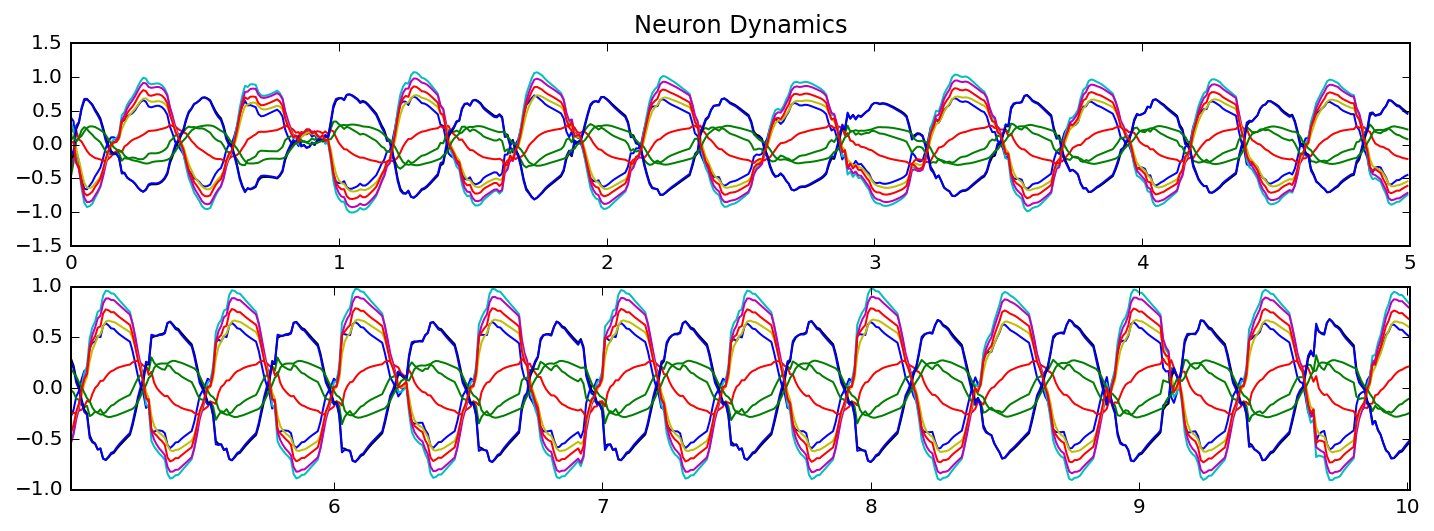

In [20]:
T = 500
plt.figure(figsize=(12,4))
plt.subplot(211)
plt.title("Neuron Dynamics");
for i in range(10):
    plt.plot(t[:T], x[:T, i]);
    
plt.subplot(212)
for i in range(10):
    plt.plot(t[-T:], x[-T:, i]);
    plt.xlim(t[-T], t[-1])

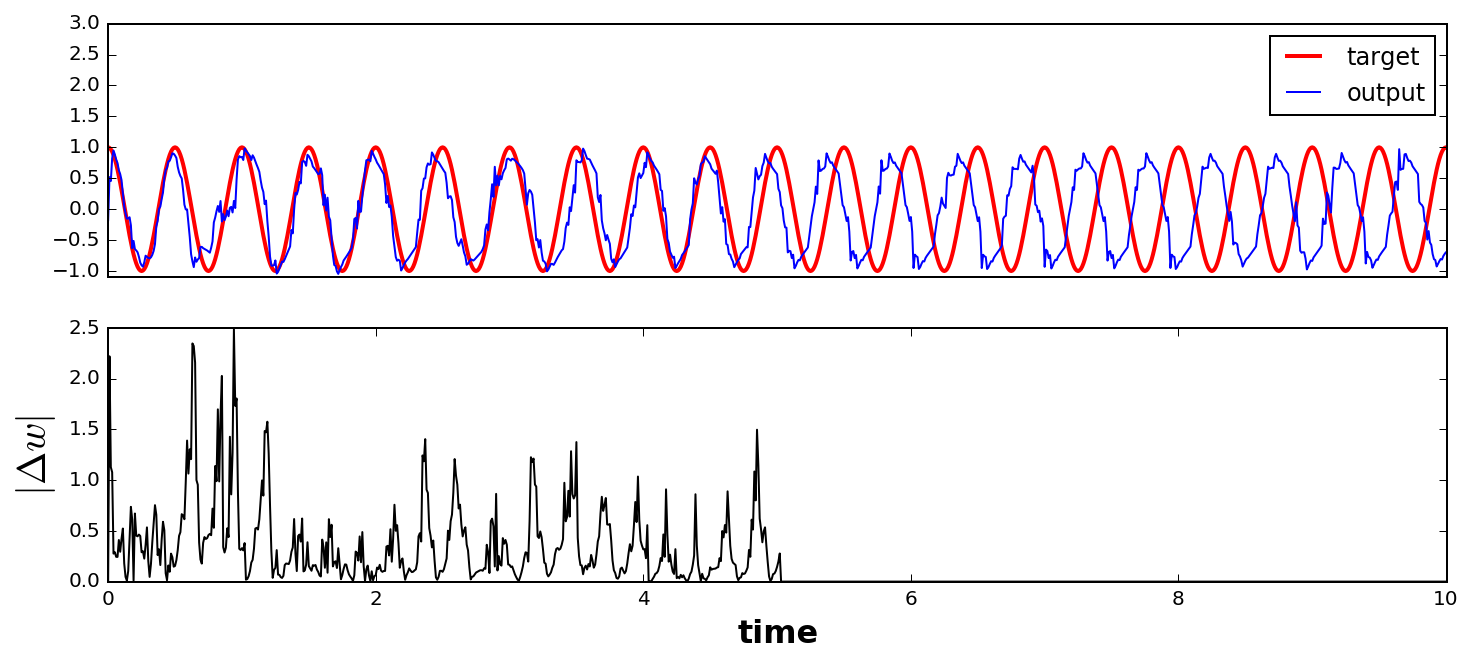

In [21]:
plt.figure(figsize=(12,5))
plot.signal_error(derrors, t, tstop, title="DFORCE (Sin Wave)", burn_in=5)
plot.target_vs_output_plus_error(t, z, wu, target, log=False)

In [22]:
pca = PCA(n_components=2)
pca.fit(x)

PCA(copy=True, n_components=2, whiten=False)

In [23]:
pca_x = pca.transform(x).T

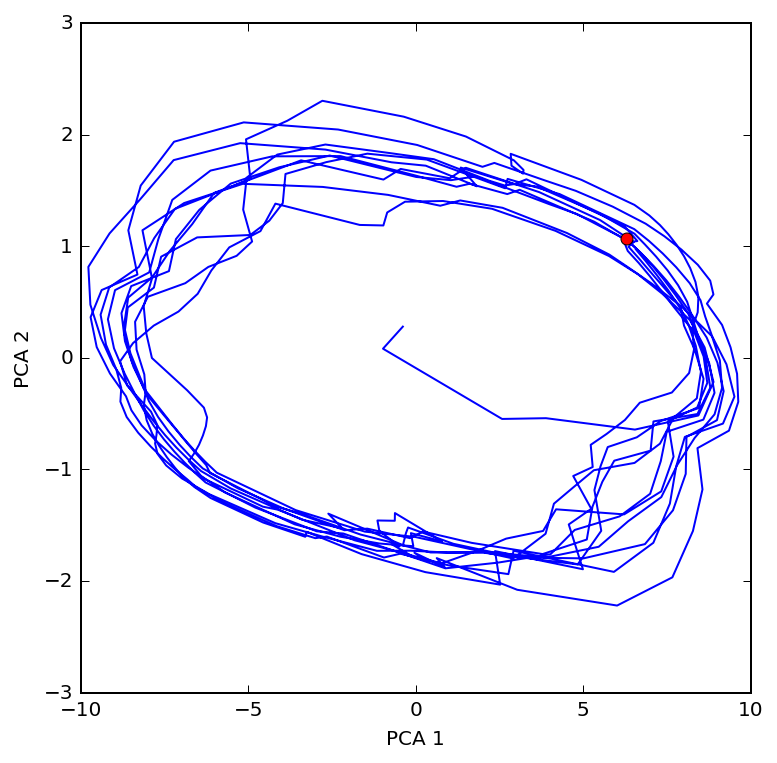

In [24]:
tmax = t[-1]
tmin = t[0]
tv = t[:-1]

interact(plot.visualize_2dim_state, time=(tmin, tmax, .1), pca_x=fixed(pca_x), tv=fixed(tv));

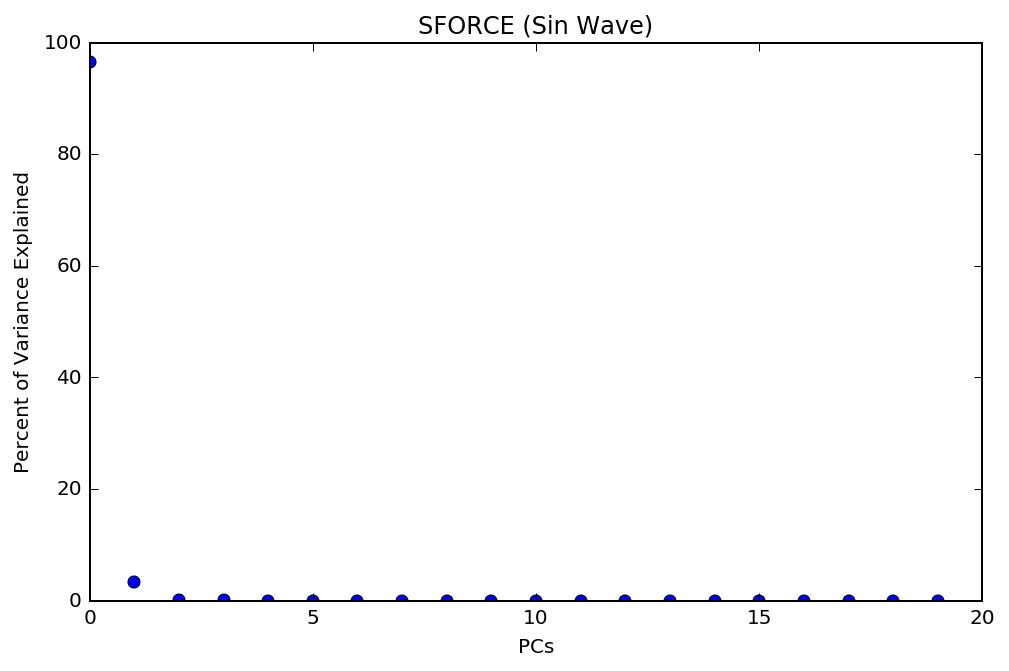

In [25]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(x)

plt.figure(figsize=(8,5))
plt.plot(100*pca.explained_variance_/sum(pca.explained_variance_), 'bo');
plt.xlabel("PCs");
plt.ylabel("Percent of Variance Explained");
plt.title("SFORCE (Sin Wave)");

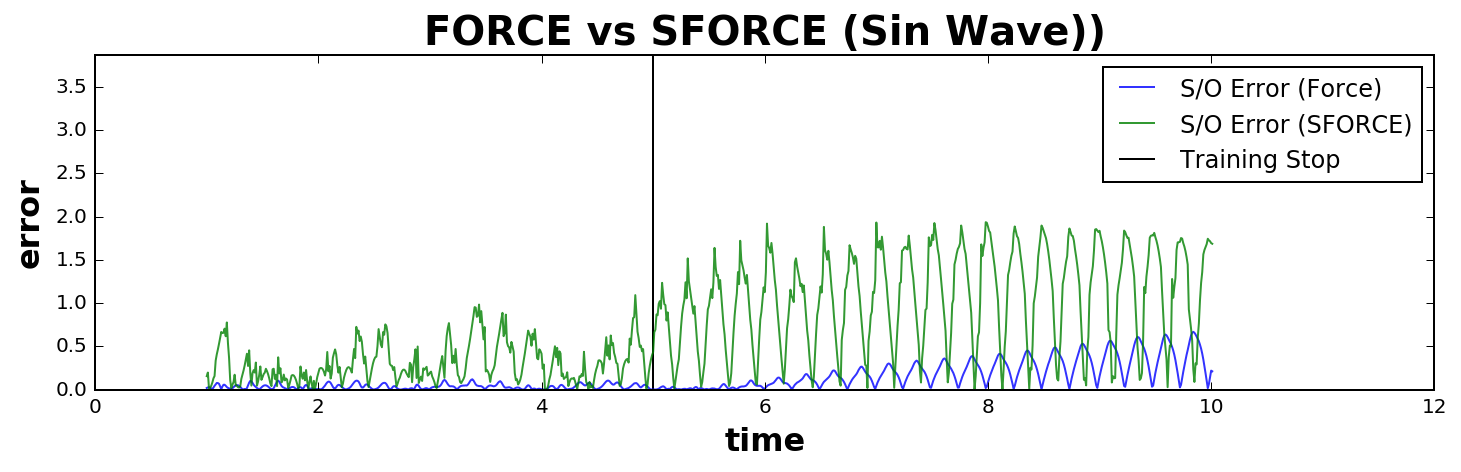

In [26]:
plt.figure(figsize=(12,3))
plot.cross_signal_error(errors, derrors, t, tstop, 
                        title="FORCE vs SFORCE (Sin Wave))", burn_in=100)

## 2) 1D Flip-Flop

In [27]:
reload(func_generator)

<module 'jedi.utils.func_generator' from '/Users/simonhaxby/Code/Python/jedi/utils/func_generator.pyc'>

In [29]:
# Plotting inputs and targets
tmax = 10
dt = .01
n = 1

inputs, targets = func_generator.flip_flop_generator(n=n, spikes=[[5,5] for _ in range(n)], t=tmax, dt=dt)
scale = 3
plt.figure(figsize=(12, scale*n))
for i in range(n):
    plt.subplot(n, 1, i+1)
    plt.plot(range(int(tmax/dt)), targets[i], label="Target");
    plt.plot(range(int(tmax/dt)), inputs[i], label="Input");
    plt.ylim(-2,2);
    plt.legend();

ValueError: operands could not be broadcast together with shapes (1000,) (2,) (1000,) 

In [30]:
targets = np.load("../data/stability/flipflop/targets_tmax10sec.npy")
inputs = np.load("../data/stability/flipflop/inputs_tmax10sec.npy")

In [31]:
# simulation parameters for FORCE
dt = .01      # time step
tmax = 10  # simulation length
tstop = 5  # learning stop time
rho = 1.02   # spectral radius of J
N = 300      # size of stochastic pool
lr = 1.0   # learning rate
pE = .8 # percent excitatory
sparsity = (.05,1,1) # sparsity
I = 1 # input size

In [32]:
errors = []
wus = []
zs = []

for seedling in seeds:
    J, Wz, Wi, x0, u, w = init_tools.set_simulation_parameters(seedling, N, I, pE=pE, p=sparsity, rho=rho)
    
    # inp & z are dummy variables
    def model(t0, x, tanh_x, inp, z):
        return (-x + dot(J, tanh_x) + dot(Wi, inp) + Wz*z)/dt
    
    x,t,z,w_learn,wu,_ = jedi.force(targets, model, lr, dt, tmax, tstop, x0, w, 0, inputs=inputs)

    zs.append(z)
    wus.append(wu)
    
    error = np.abs(z-np.array(targets))
    errors.append(error)
    
errors = np.array(errors)

Simulation run-time (wall): 2.753 seconds


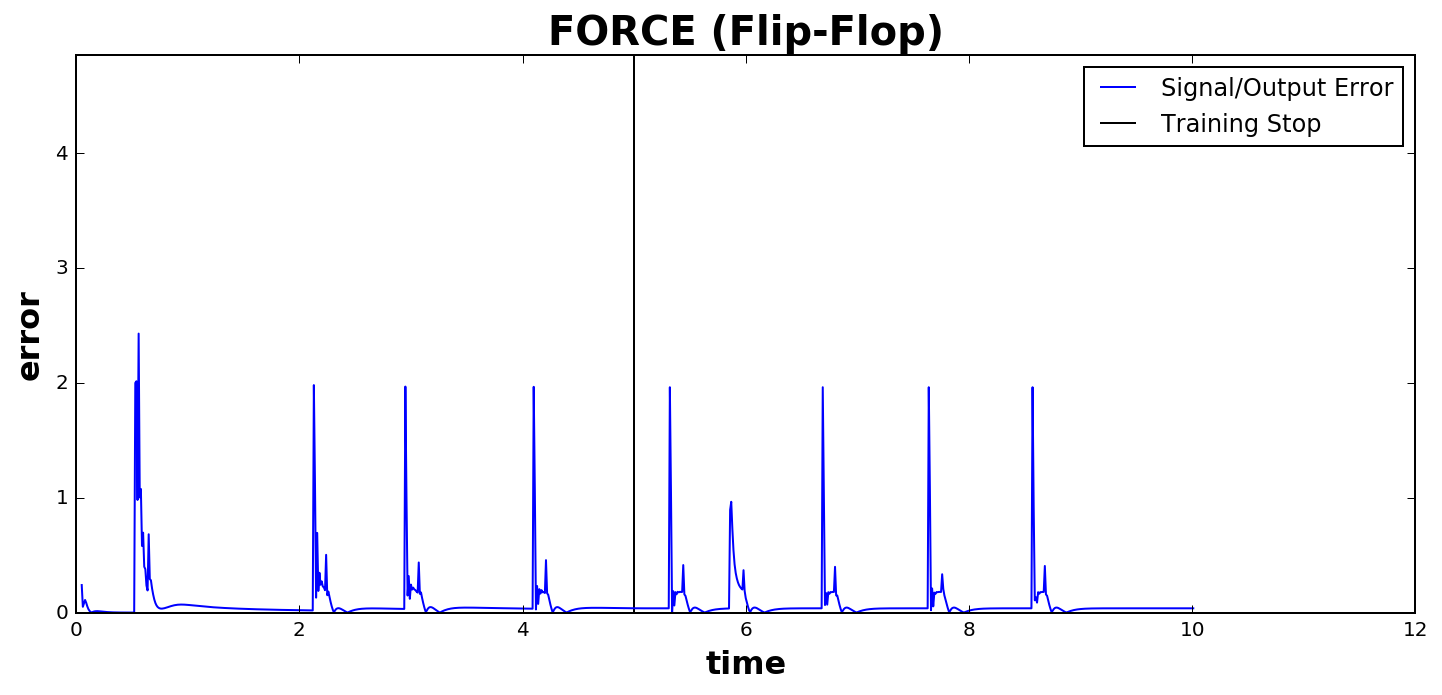

In [33]:
plt.figure(figsize=(12,5))
plot.signal_error(errors, t, tstop, title= "FORCE (Flip-Flop)", burn_in=5)

In [34]:
ind = 0

Seed: 0


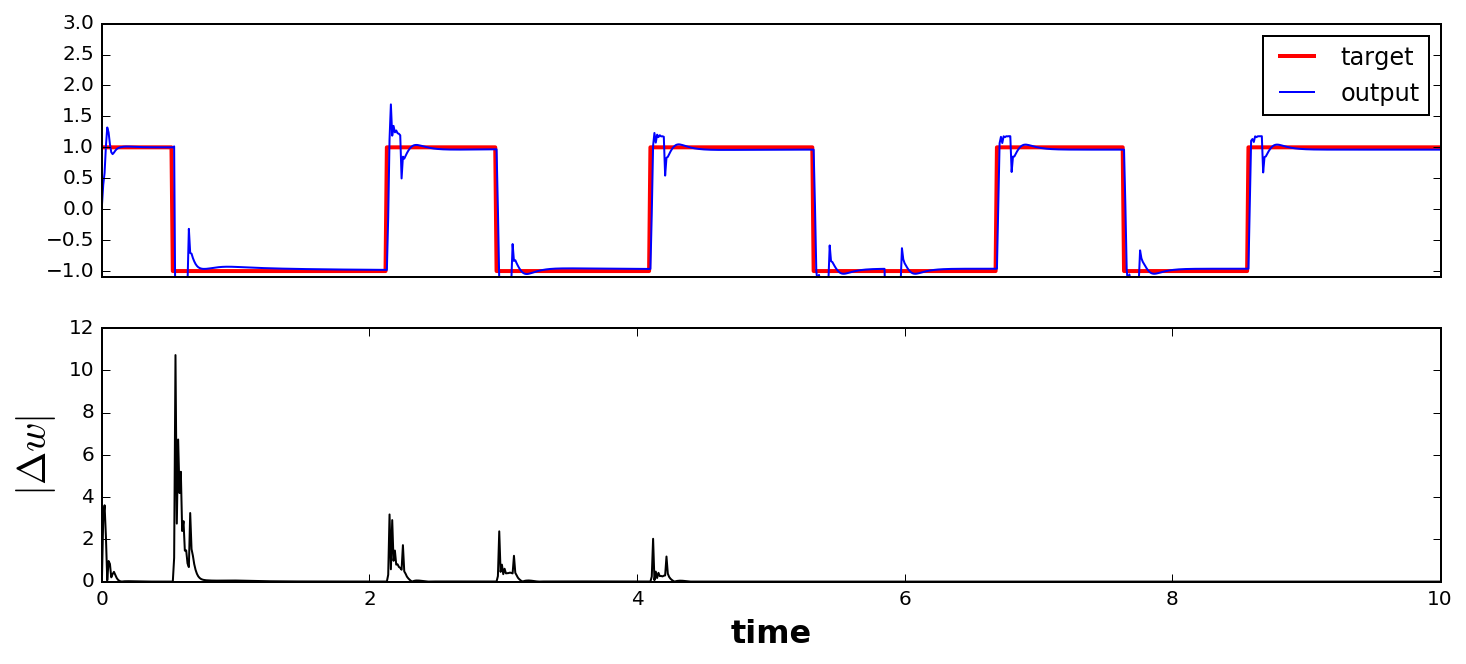

In [35]:
plt.figure(figsize=(12,5))
if ind < len(seeds):
    print("Seed: %d" % ind)
    plot.target_vs_output_plus_error(t, zs[ind], wus[ind], targets, offset=0, log=False)
    ind+=1

/Users/simonhaxby/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


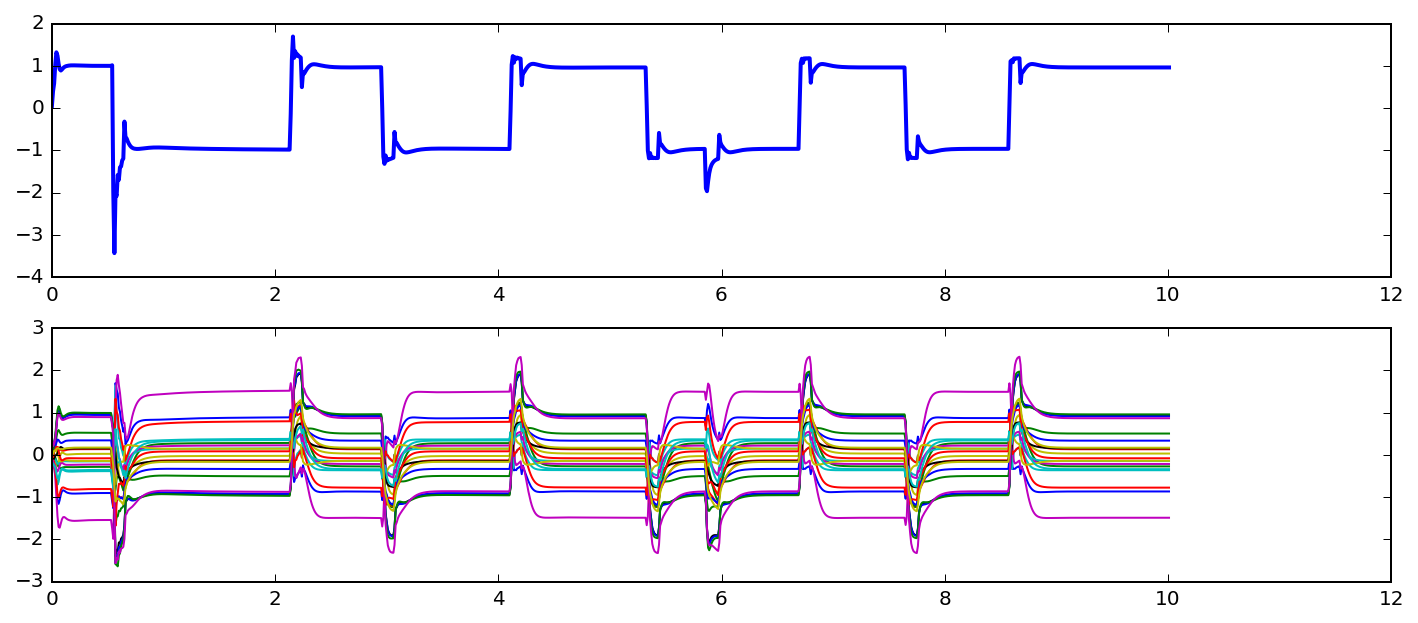

In [36]:
plt.figure(figsize=(12,5))
plt.legend()
plt.subplot(2,1,2)
for i in range(20):
    plt.plot(t[:], x[:, i]);
plt.subplot(2,1,1)
plt.plot(t, np.array(z), lw=2, label="output");

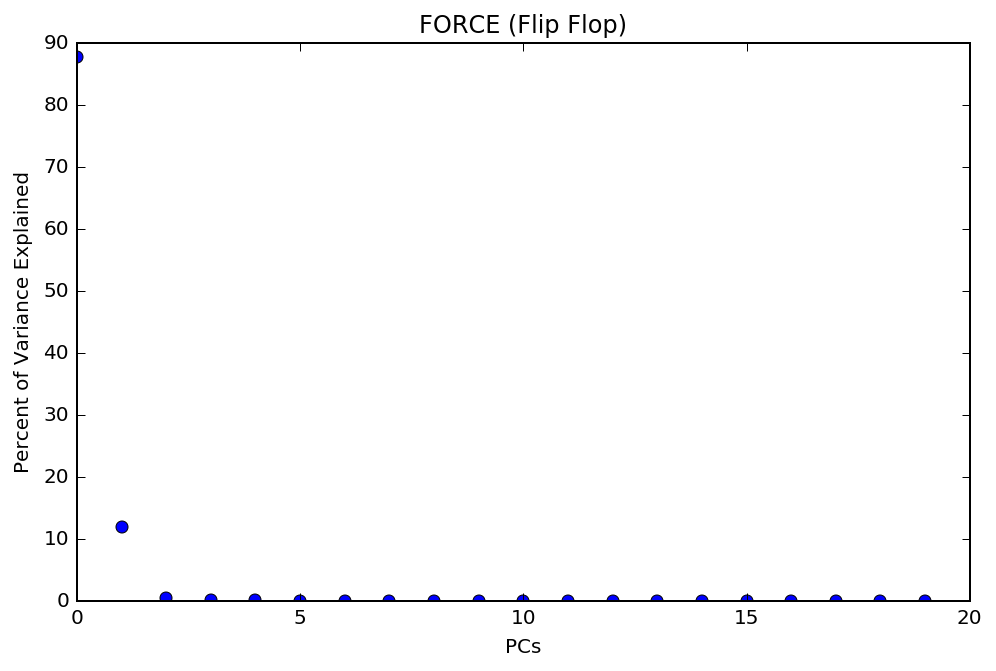

In [37]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(x)

plt.figure(figsize=(8,5))
plt.plot(100*pca.explained_variance_/sum(pca.explained_variance_), 'bo');
plt.xlabel("PCs");
plt.ylabel("Percent of Variance Explained");
plt.title("FORCE (Flip Flop)");

In [38]:
pca = PCA(n_components=2)
pca.fit(x)
pca_x = pca.transform(x).T

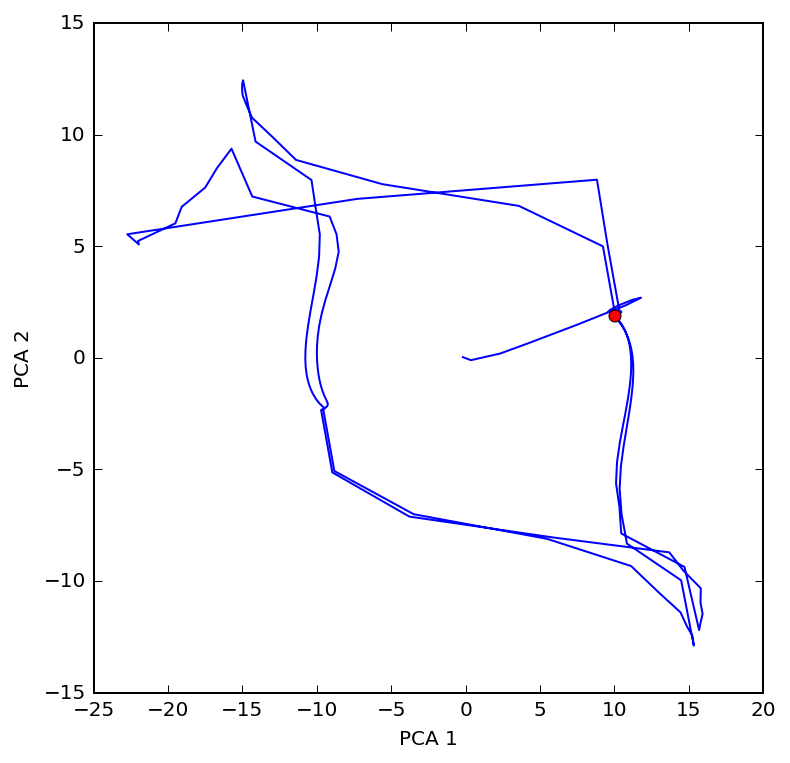

In [39]:
tmax = t[-1]
tmin = t[0]
tv = t[:-1]

interact(plot.visualize_2dim_state, time=(tmin, tmax, .1), pca_x=fixed(pca_x), tv=fixed(tv));

In [40]:
# simulation parameters for FORCE
dt = .01      # time step
tmax = 10  # simulation length
tstop = 5  # learning stop time
rho = 1.02   # spectral radius of J
N = 300      # size of stochastic pool
lr = 1.0   # learning rate
pE = .8 # percent excitatory
sparsity = (.1,1,1) # sparsity
I = 1 # input size

In [41]:
derrors = []
wus = []
zs = []

for seedling in seeds:
    J, Wz, Wi, x0, u, w = init_tools.set_simulation_parameters(seedling, N, I, pE=pE, p=sparsity, rho=rho)
    
    # inp & z are dummy variables
    def model(t0, x, tanh_x, inp, z):
        return (-x + dot(J, tanh_x) + dot(Wi, inp) + Wz*z)/dt
    
    x,t,z,w_learn,wu,_ = jedi.dforce(jedi.step_decode, targets, model, lr, dt, tmax, tstop, x0, w, 0, 
                                     pE=.8, inputs=inputs)

    zs.append(z)
    wus.append(wu)
    
    derror = np.abs(z-np.array(targets))
    derrors.append(derror)
    
derrors = np.array(derrors)

Simulation run-time (wall): 2.333 seconds


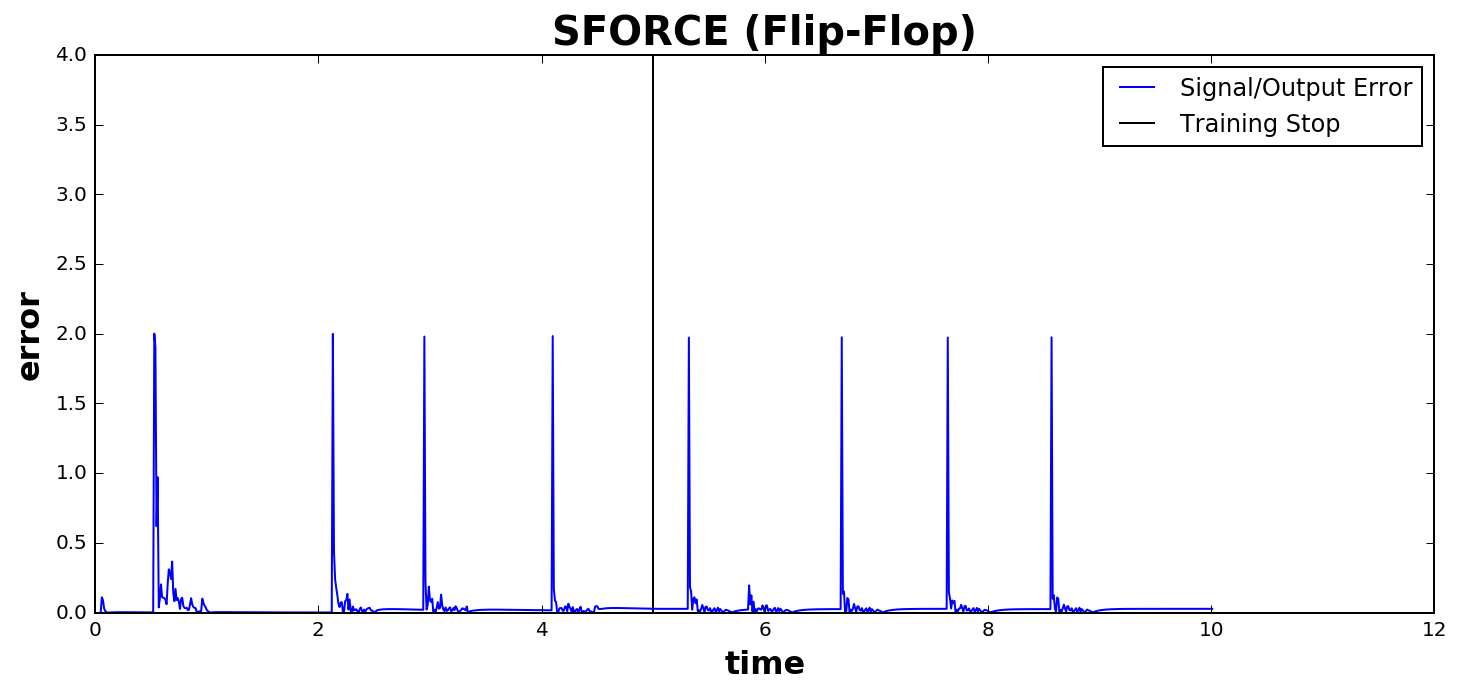

In [42]:
plt.figure(figsize=(12,5))
plot.signal_error(derrors, t, tstop, title="SFORCE (Flip-Flop)", burn_in=5)

In [43]:
# Setting seed index
ind = 0

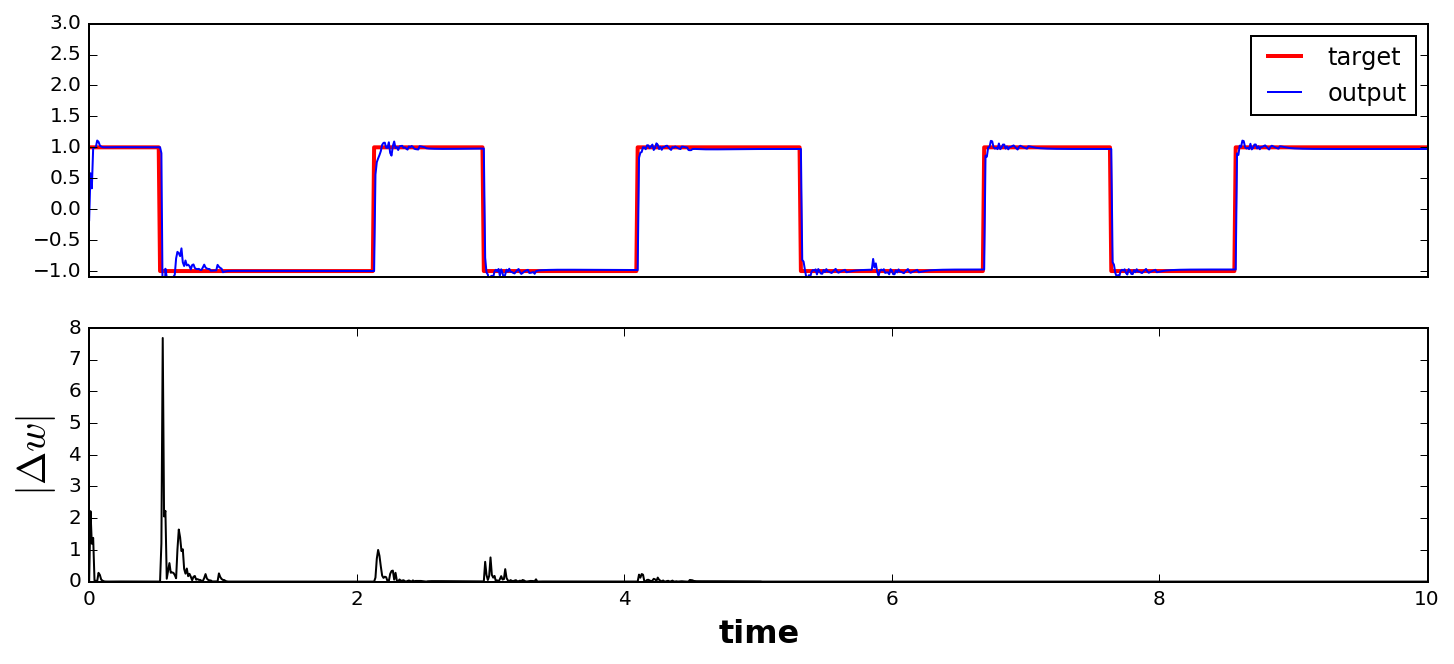

In [44]:
plt.figure(figsize=(12,5))
plot.target_vs_output_plus_error(t, zs[ind], wus[ind], targets, offset=0, log=False)

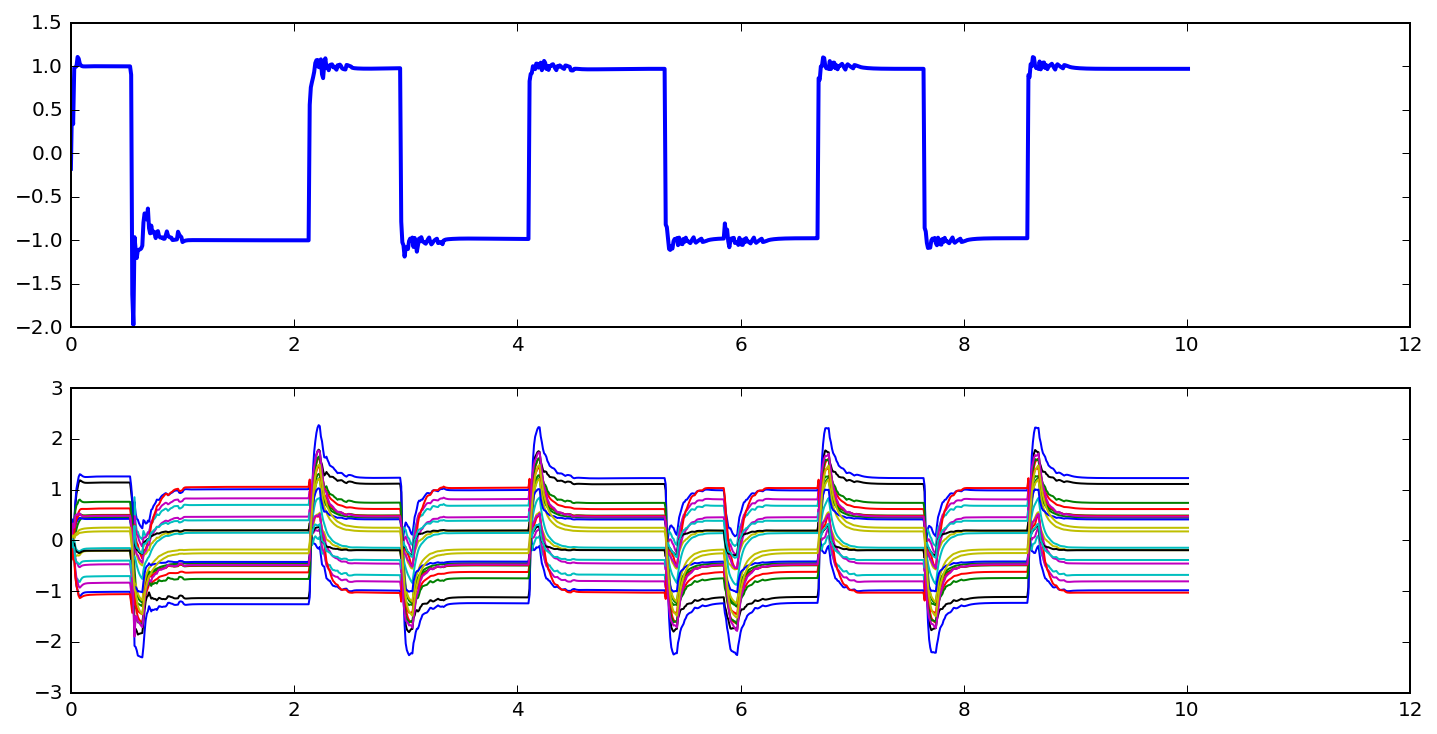

In [45]:
plt.figure(figsize=(12,6))
plt.legend()
plt.subplot(2,1,2)
for i in range(20):
    plt.plot(t[:], x[:, i]);
plt.subplot(2,1,1)
plt.plot(t, np.array(z), lw=2, label="output");

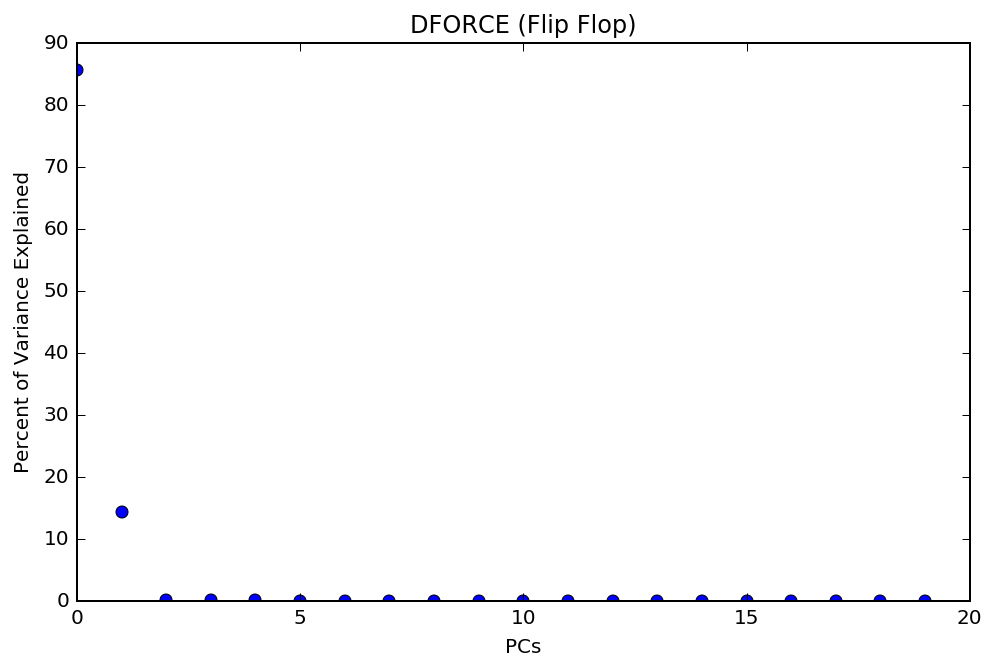

In [46]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(x)

plt.figure(figsize=(8,5))
plt.plot(100*pca.explained_variance_/sum(pca.explained_variance_), 'bo');
plt.xlabel("PCs");
plt.ylabel("Percent of Variance Explained");
plt.title("DFORCE (Flip Flop)");

In [151]:
pca = PCA(n_components=2)
pca.fit(x)
pca_x = pca.transform(x).T

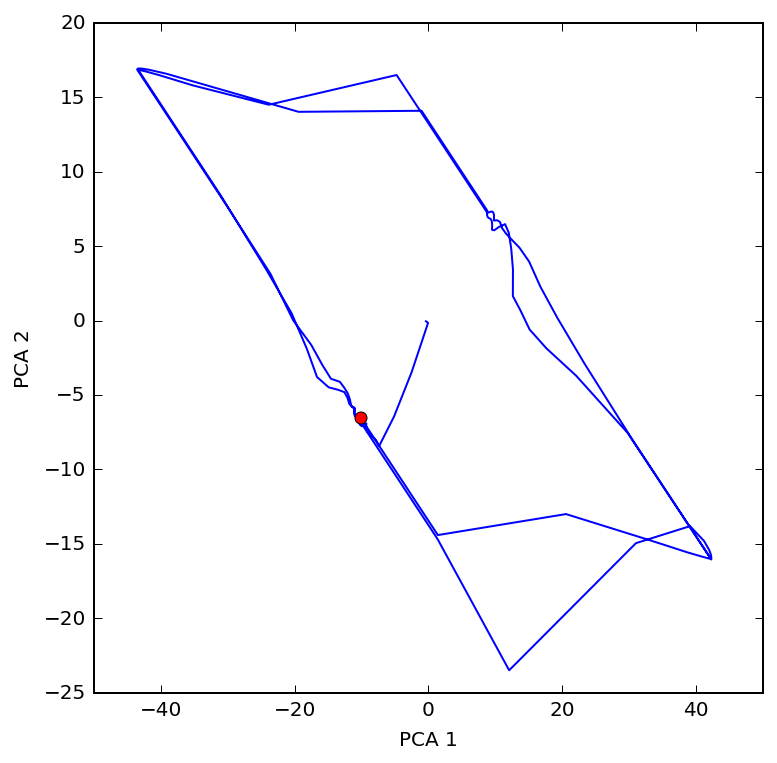

In [152]:
tmax = t[-1]
tmin = t[0]
tv = t[:-1]

interact(plot.visualize_2dim_state, time=(tmin, tmax, .1), pca_x=fixed(pca_x), tv=fixed(tv));

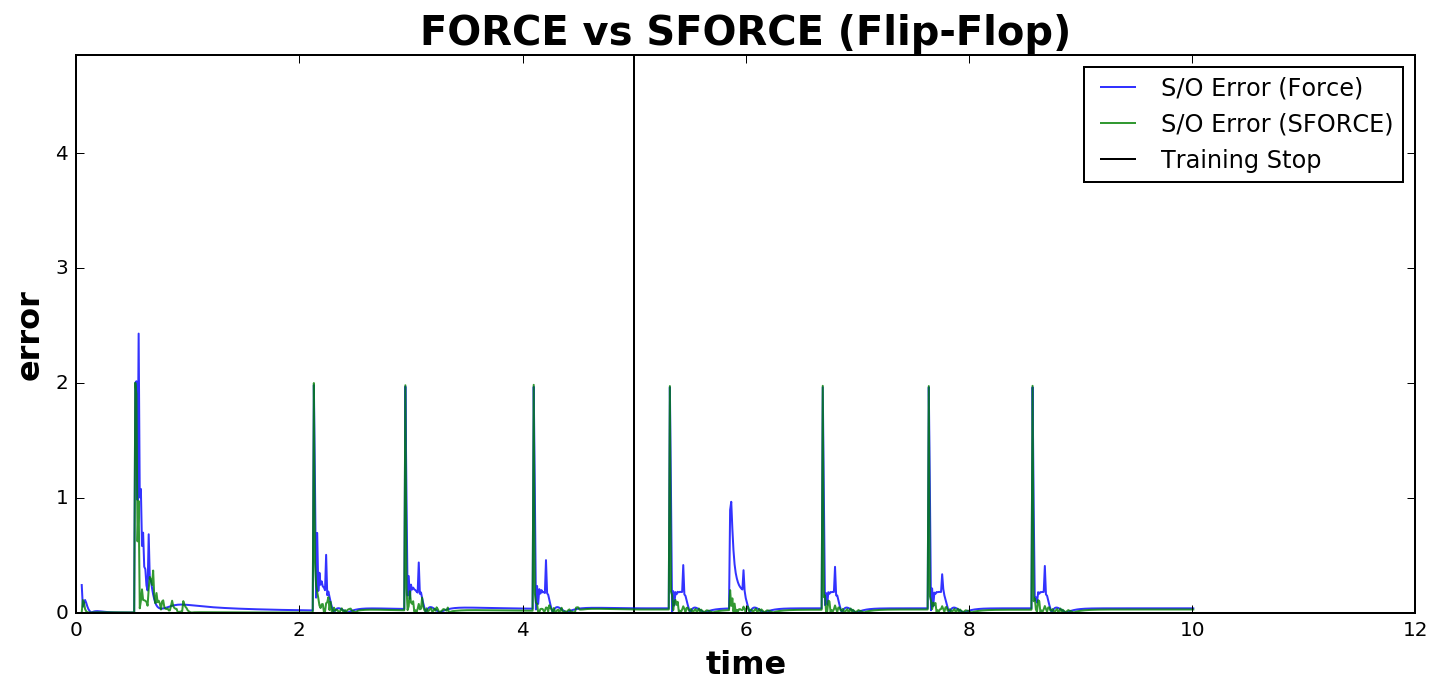

In [47]:
# cross mean signal error
plt.figure(figsize=(12,5))
plot.cross_signal_error(errors, derrors, t, tstop, 
                        title="FORCE vs SFORCE (Flip-Flop)", burn_in=5)

In [154]:
# Setting seed index
ind = 0

Seed: 0


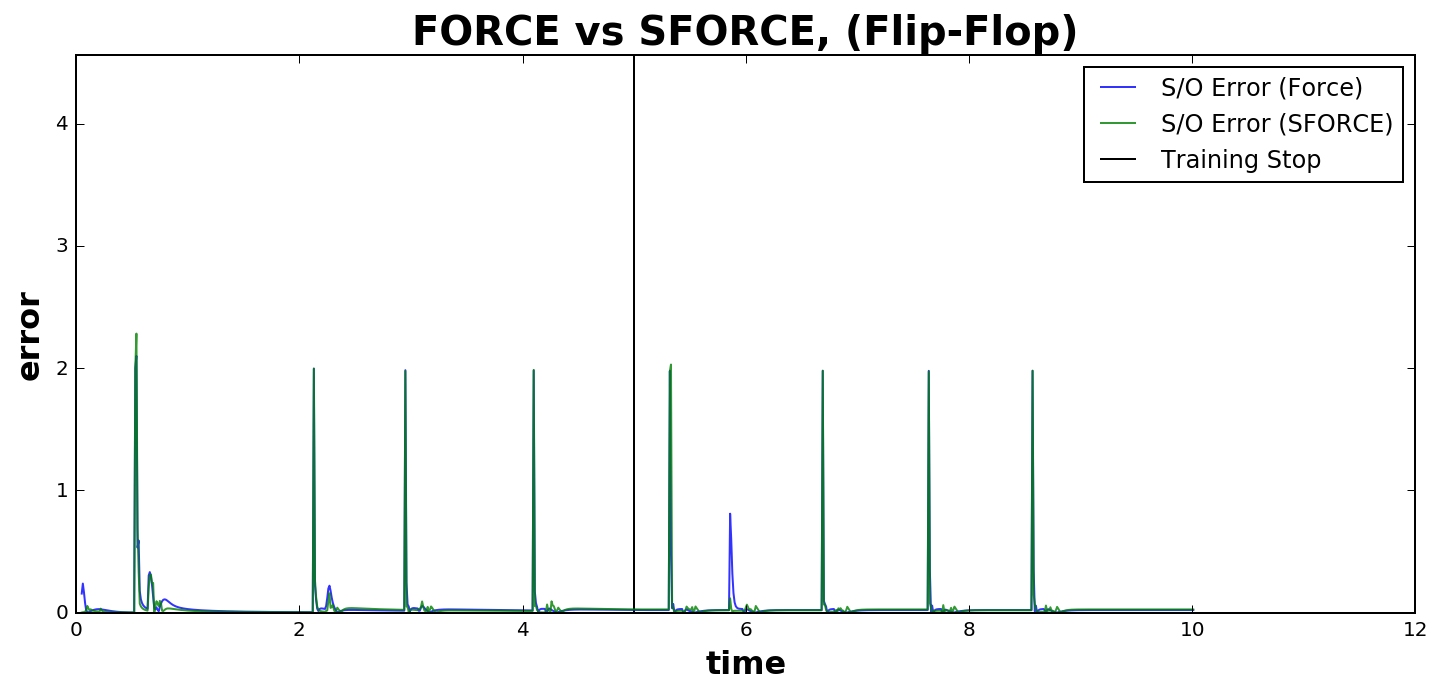

In [155]:
plt.figure(figsize=(12,5))
print("Seed: %d" % ind)
plot.cross_signal_error(errors[ind], derrors[ind], t, tstop, 
                        title="FORCE vs SFORCE, (Flip-Flop)", 
                        burn_in=5, mean=False)
ind+=1

## 3) Lorentz Attractor

In [48]:
# Parameters specified by Abbott 2009.
def lorentz((x, y, z), t0, sigma=10., beta=8./3, rho=28.0):
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

In [49]:
break_in = 500
T = 1501 # period
x0 = np.random.randn(3) # starting vector
t_= np.linspace(0, 60, T)
lorenz = odeint(lorentz, x0, t_)/20
targets = lorenz[break_in:,0]
t_in = t_[break_in:]

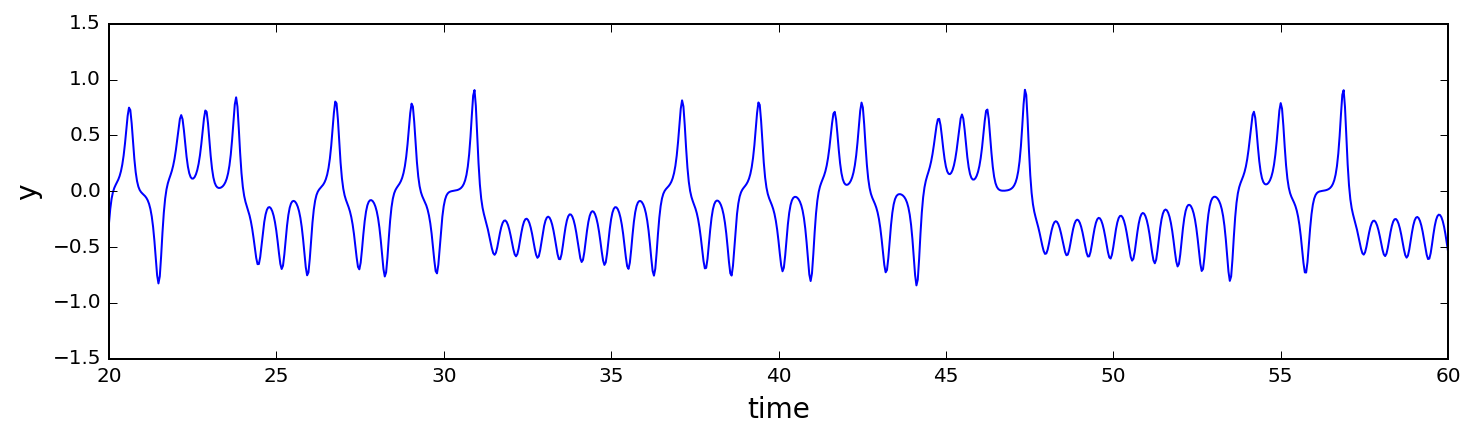

In [50]:
# Visualizing Lorentz attractor
plt.figure(figsize=(12,3))
plt.plot(t_in, targets);
plt.xlim([min(t_in), max(t_in)])
plt.ylim([-1.5,1.5])
plt.xlabel('time', fontsize=14);
plt.ylabel('y', fontsize=14);

In [51]:
# simulation parameters for FORCE
dt = .01      # time step
tmax = 10  # simulation length
tstop = 8  # learning stop time
rho = 1.2   # spectral radius of J
N = 1000     # size of stochastic pool
lr = 1.0   # learning rate
pE = None # percent excitatory
sparsity = (.1,1,1) # sparsity

In [52]:
errors = []
wus = []
zs = []

for seedling in seeds:
    J, Wz, _, x0, u, w = init_tools.set_simulation_parameters(seedling, N, 1, pE=pE, p=sparsity, rho=rho)
    
    # inp & z are dummy variables
    def model(t0, x, tanh_x, inp, z): 
        return (-x + dot(J, tanh_x) + Wz*z)/dt 
    
    x, t, z, _, wu,_ = jedi.force(targets, model, lr, dt, tmax, tstop, x0, w, 0)

    zs.append(z)
    wus.append(wu)
    
    error = np.abs(z[1:]-np.array(targets))
    errors.append(error)
    
errors = np.array(errors)

Simulation run-time (wall): 80.344 seconds


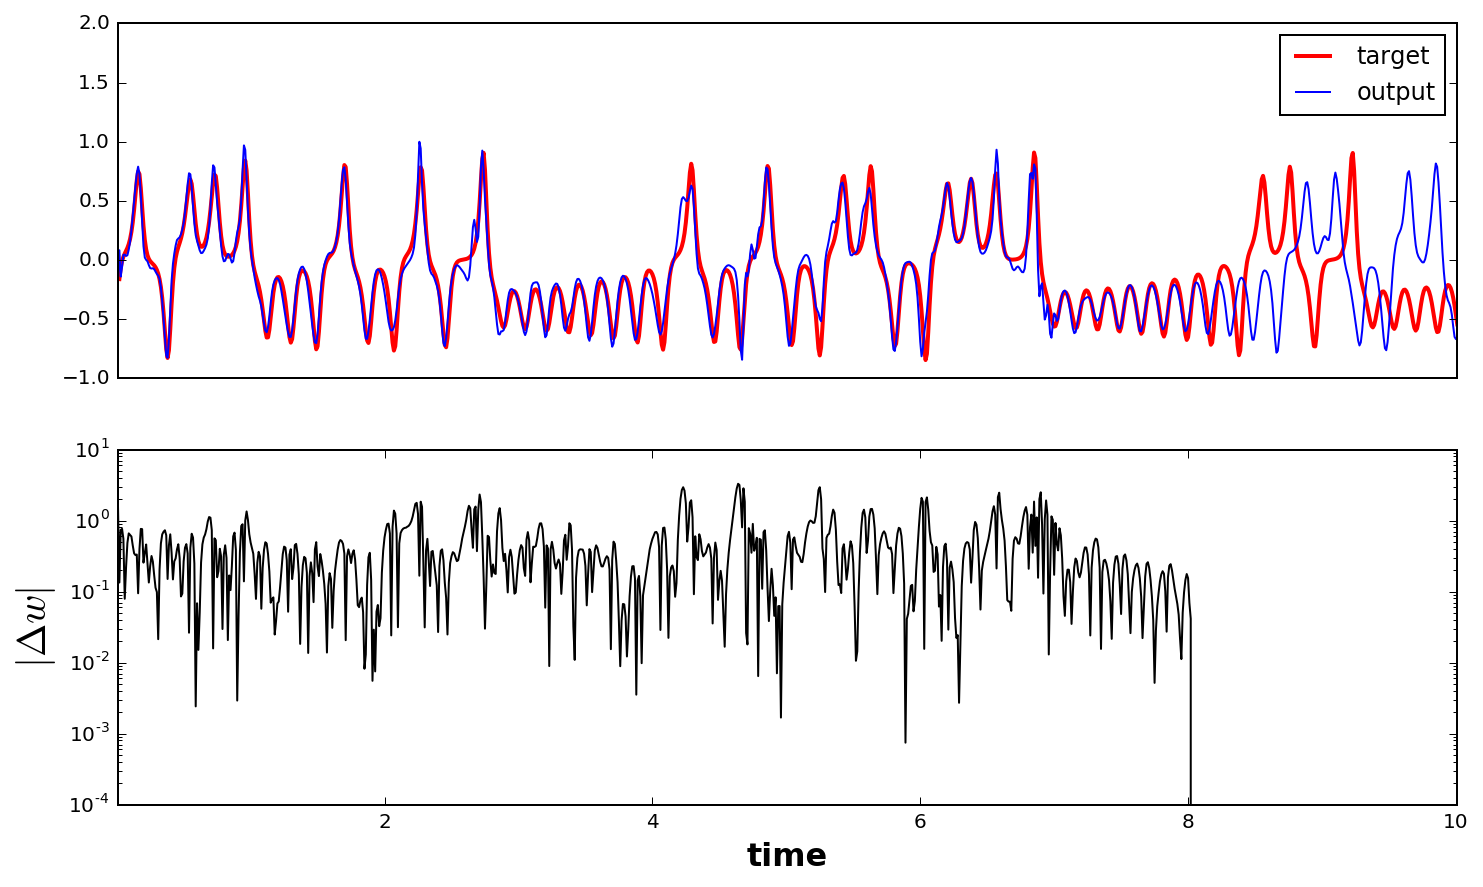

In [53]:
plt.figure(figsize=(12,7))
ind = 0  
tstart = 1
plot.target_vs_output_plus_error(t[tstart:], zs[ind][tstart:], 
                                 wus[ind][tstart:], targets[tstart:], offset=1, ylim=[-1,2])

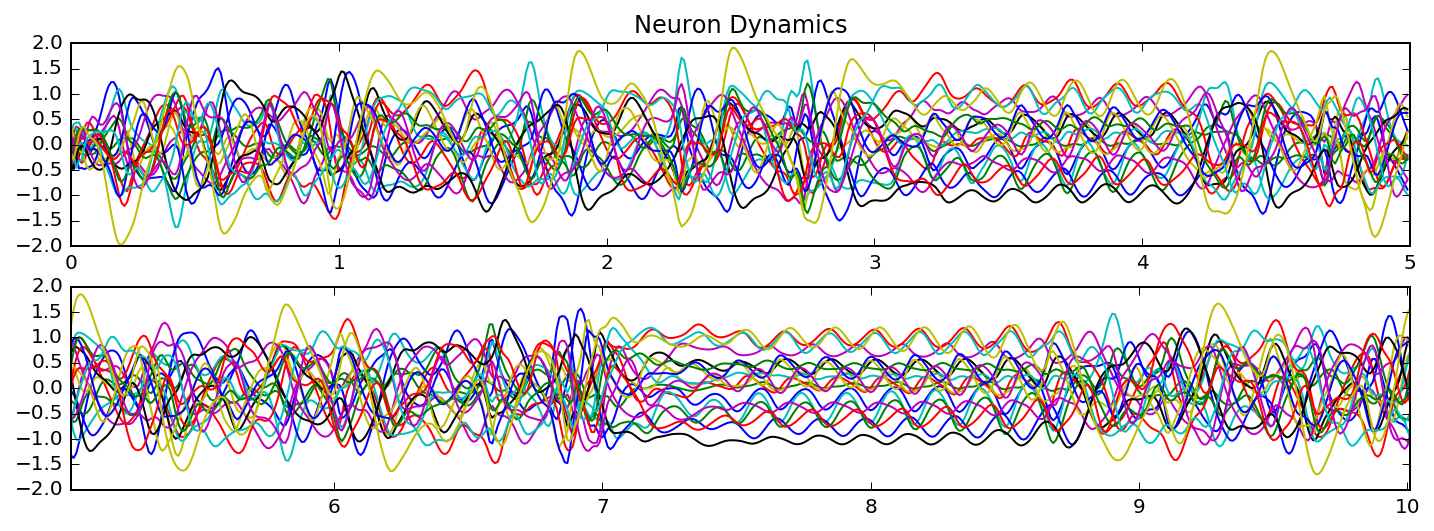

In [54]:
# Visualizing activities of first 20 neurons
T = 500
K = 20

plt.figure(figsize=(12,4))
plt.subplot(211)
plt.title("Neuron Dynamics");
for i in range(K):
    plt.plot(t[:T], x[:T, i]);
    
plt.subplot(212)
for i in range(K):
    plt.plot(t[-T:], x[-T:, i]);
    plt.xlim(t[-T], t[-1])

In [ ]:
plt.figure(figsize=(12,5))
plot.signal_error(errors, t[1:], tstop, title= "FORCE", burn_in=5)

In [ ]:
ind = 0

In [ ]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(x)

plt.figure(figsize=(8,5))
plt.plot(100*pca.explained_variance_/sum(pca.explained_variance_), 'bo');
plt.xlabel("PCs");
plt.ylabel("Percent of Variance Explained");
plt.title("FORCE (Flip Flop)");

In [ ]:
pca = PCA(n_components=3)
pca.fit(x)
pca_x = pca.transform(x).T

In [ ]:
tmax = t[-1]
tmin = t[0]
tv = t[:-1]

interact(plot.visualize_3dim_state, time=(tmin, tmax, .1), pca_x=fixed(pca_x), tv=fixed(tv));

In [170]:
# simulation parameters for FORCE
dt = .01      # time step
tmax = 10  # simulation length
tstop = 8  # learning stop time
rho = 1.2   # spectral radius of J
N = 1000     # size of stochastic pool
lr = 1.0   # learning rate
pE = None # percent excitatory
sparsity = (.1,1,1) # sparsity

In [172]:
derrors = []
wus = []
zs = []

for seedling in seeds:
    J, Wz, _, x0, u, w = init_tools.set_simulation_parameters(seedling, N, 1, pE=pE, p=sparsity, rho=rho)
    
    # inp & z are dummy variables
    def model(t0, x, tanh_x, inp, z): 
        return (-x + dot(J, tanh_x) + Wz*z)/dt 
    
    x, t, z, _, wu,_ = jedi.dforce(jedi.step_decode, targets, model, lr, dt, tmax, tstop, x0, w, 0, pE=.8)

    zs.append(z)
    wus.append(wu)
    
    derror = np.abs(z[1:]-np.array(targets))
    derrors.append(derror)
    
derrors = np.array(derrors)

Simulation run-time (wall): 71.538 seconds


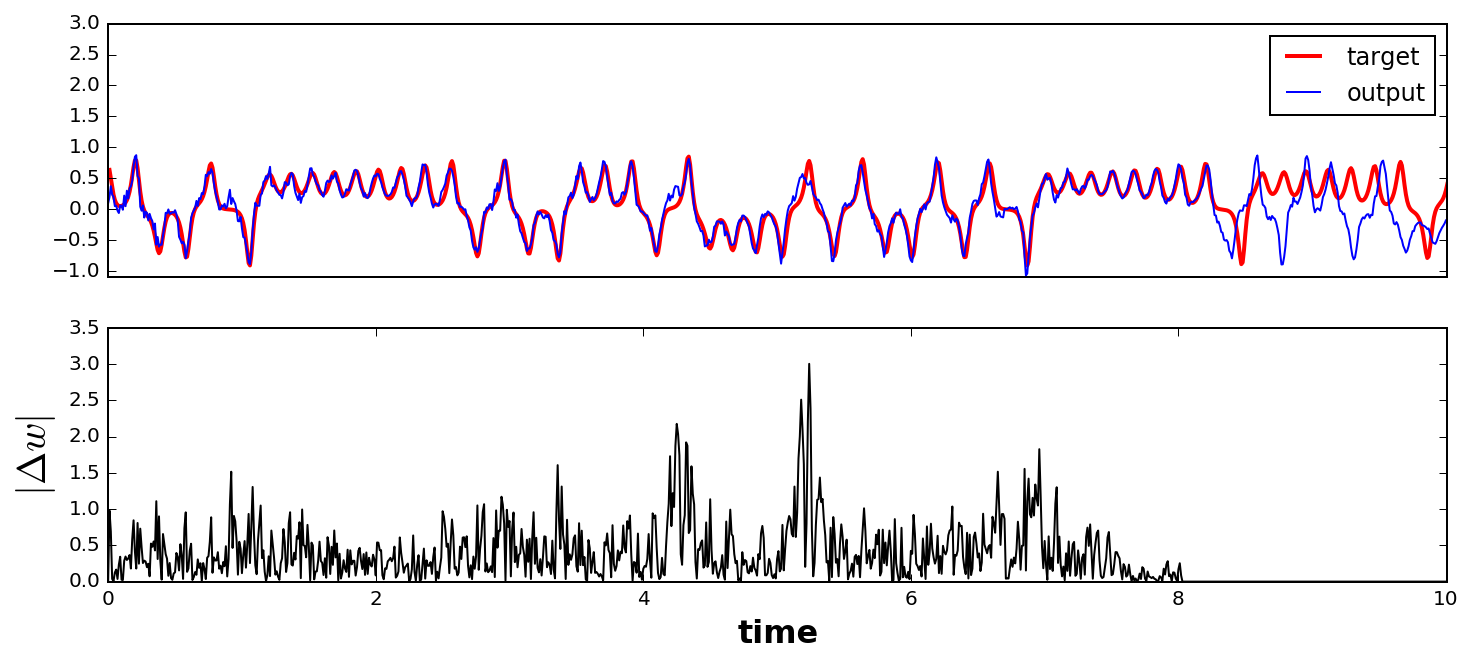

In [173]:
plt.figure(figsize=(12,5))
ind = 0 
plot.target_vs_output_plus_error(t, zs[ind], wus[ind], targets, offset=1, log=False)

In [ ]:
plt.figure(figsize=(12,4))
plot.signal_error(derrors, t[1:], tstop, title= "SFORCE", burn_in=5)

In [ ]:
plt.figure(figsize=(12,5))
print("Seed: %d" % ind)
plot.signal_error(derrors[ind], t[1:], tstop, 
                  title= "SFORCE", burn_in=5, mean=False)
plot.target_vs_output_plus_error(t, zs[ind], wus[ind], targets, offset=1, log=False)
ind+=1

In [ ]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(x)

plt.figure(figsize=(8,5))
plt.plot(100*pca.explained_variance_/sum(pca.explained_variance_), 'bo');
plt.xlabel("PCs");
plt.ylabel("Percent of Variance Explained");
plt.title("SFORCE (Flip Flop)");

In [ ]:
pca = PCA(n_components=3)
pca.fit(x)
pca_x = pca.transform(x).T

In [ ]:
tmax = t[-1]
tmin = t[0]
tv = t[:-1]

interact(plot.visualize_3dim_state, time=(tmin, tmax, .1), pca_x=fixed(pca_x), tv=fixed(tv));

In [ ]:
# cross mean signal error
plot.cross_signal_error(errors, derrors, t[1:], tstop, 
                        title="FORCE vs SFORCE (Lorentz)", burn_in=5)